# NCEM

Package output:
 - Coupling analysis: DEGs
 - Coupling analysis circular: DEGs or magnitude
 - Sender effect on receiving cell
 - Sender-receiver vulcano plot
 - **Sender similarity analysis**
 - **custom_sender_receiver_

Not functioning:
 - Grid searches over neighbourhood sizes + Length scales of dependencies for different target cell-types
 - (Squidpy CellPhoneDB)

Outlook:
- Future custom loader

To-do:
- Bug in custom wrapper function
  - Gene filter by q-val threshold isn't working properly


In [1]:
%load_ext autoreload
%autoreload 2

import ncem
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
mpl.rcParams['savefig.dpi'] = 600

import warnings
warnings.filterwarnings("ignore")

2023-03-01 14:14:24.294908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 14:14:24.396995: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 14:14:24.775608: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 14:14:24.775649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

### 0. Loading the data with the predefined data loader

In [2]:
interpreter = ncem.interpretation.interpreter.InterpreterInteraction()
interpreter.get_data(
    data_origin='hartmann', # Reference to specfic DataLoader (see notes in Dropbox paper)
    data_path='../input-data/raw-data/Hartmann-2021/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.98it/s]

Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036

 Celldata metadata: {'lateral_resolution': 0.390625, 'fn': ['scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv', 'scMEP_sample_description.xlsx'], 'image_col': 'point', 'pos_cols': ['center_colcoord', 'center_rowcoord'], 'cluster_col': 'Cluster', 'cluster_col_preprocessed': 'Cluster_preprocessed', 'patient_col': 'donor'}


0.0
1.000547499859607
10.193272571484671
128.1181909355233
1071.8057746883462


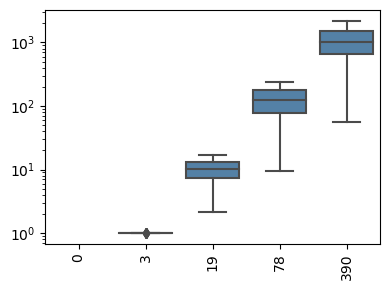

In [3]:
# node degrees for different radii (real distance)
interpreter.data.plot_degree_vs_dist(
    max_distances=[0, 10, 50, 200, 1000],
    lateral_resolution=400/1024, # Physical cell resolution
)

### 1 Data exploration


##### Variance decomposition

100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


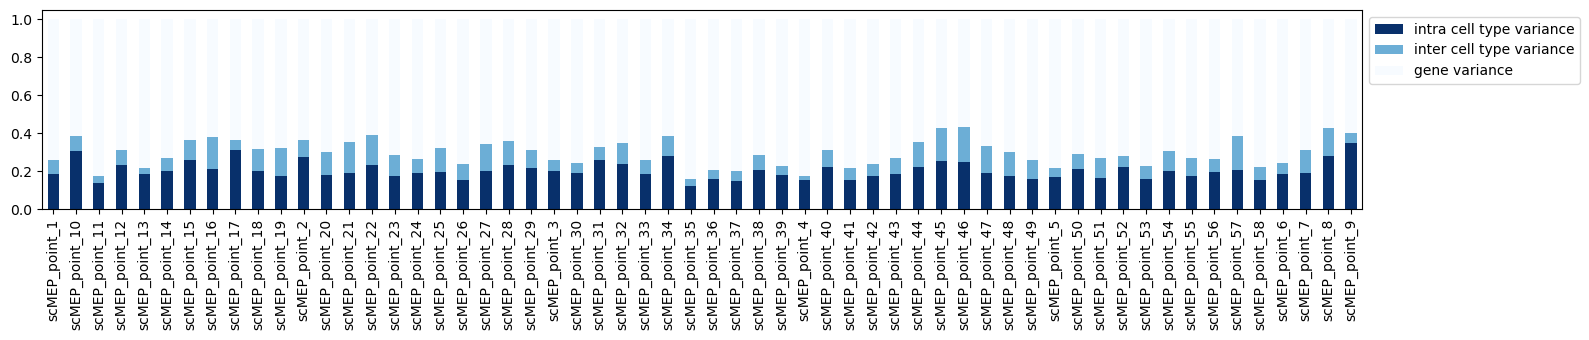

In [4]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')
interpreter.data.variance_decomposition(var_decomp)



In [5]:
var_decomp.mean(axis=0)[['intra cell type variance', 'inter cell type variance', 'gene variance']]

intra cell type variance    0.203625
inter cell type variance    0.092683
gene variance               0.703692
dtype: float32

##### Normalised contact frequencies of cell-types in spatial neighborhoods


100%|██████████| 58/58 [00:00<00:00, 103.67it/s]


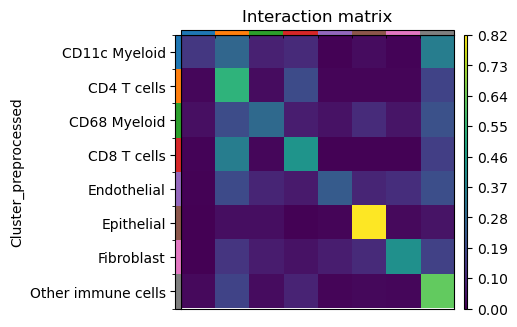

In [6]:
interpreter.data.celldata_interaction_matrix(figsize=(3,3))

#### Distributional characteristics of gene expression measurements of single cells from spatial molecular profiling assays.

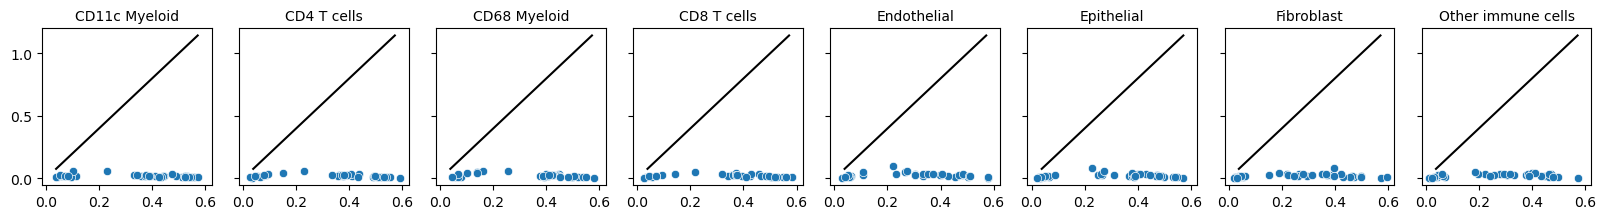

In [7]:
interpreter.data.noise_structure()


### 1. Grid searches over neighbourhood sizes

In [8]:
# gs = ncem.train.GridSearchContainer(
#     source_path=os.path.join('input-data/raw-data/Hartmann-2021/' + 'grid_searches_gen/'), 
#     gs_ids=[
#         "210419_INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1_HARTMANN",
#         "210419_INTERACTIONS_MAX_NODES_IMAGE_1_HARTMANN",
#     ],
#     lateral_resolution = 400/1024
# )
# gs.load_gs()

# gs.plot_best_model_by_hyperparam(
#     graph_model_class='interactions',
#     baseline_model_class='interactions_baseline',
#     rename_levels = [
#         ("model", {
#             "INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1": "baseline",
#             "INTERACTIONS_MAX_NODES_IMAGE_1": "NCEM",
#         })
#     ],
#     xticks=[0, 10, 50, 200, 1000],
# )

#### Length scales of dependencies for different target cell-types.

In [9]:
# gs.load_target_cell_evaluation()
# gs.plot_target_cell_evaluation(
#     metric_show="r_squared_linreg",
#     metric_select="r_squared_linreg",
#     param_x="um_radius",
# )

### 2. Extracting sender-receiver effects with NCEM

In [5]:
# splitting data into test and validation sets, can be ignored for non sender-receiver focused analysis
interpreter.split_data_node(0.1, 0.1)
interpreter.n_eval_nodes_per_graph = 10
interpreter.cell_names = list(interpreter.data.celldata.uns['node_type_names'].values())

Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51914 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 



In [6]:
interpreter.get_sender_receiver_effects()

2023-03-01 14:15:25.465399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 14:15:25.490419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 14:15:25.490581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 14:15:25.492111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

using ols parameters.
calculating inv fim.


### Type coupling analysis

Heatmap color is proportional to the number of differentially expressed genes at a FDR-corrected p-value threshold of 0.05 for each pair of sender and receiver cell types. 

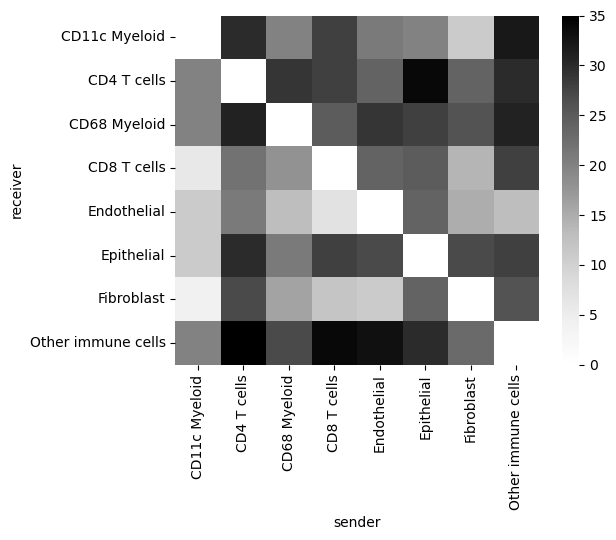

In [12]:
interpreter.type_coupling_analysis(figsize=(6.5, 5.5))

Edge width proportional to the number of differentially expressed genes at a FDR-corrected p-value threshold of 0.05 for each pair of sender and receiver cell types. Only edges with eat least 24 differentially expressed genes are shown.


**Arrow thickness:** strength of directional dependencies between cell types as the magnitude of the corresponding coefficient vector

/home/ifichtner/mambaforge/envs/squidpyLatest/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


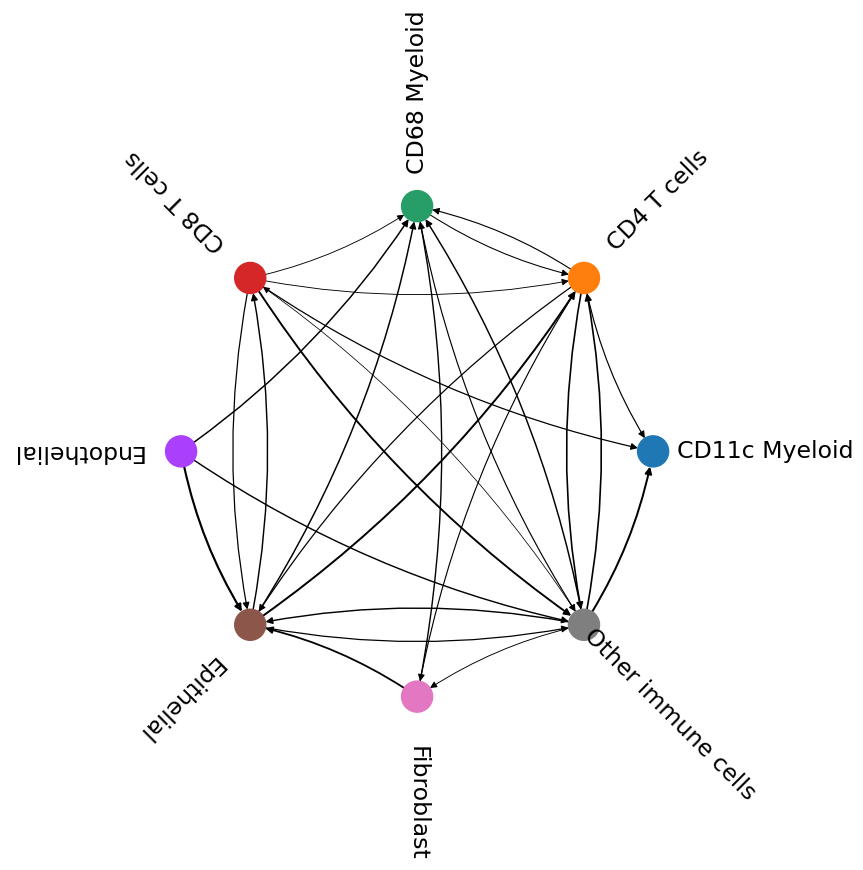

,sender,receiver,0,magnitude,de_genes,de_genes_abs
1,CD11c Myeloid,CD4 T cells,20,0.198203,0.516129,20
2,CD11c Myeloid,CD68 Myeloid,20,0.187180,0.516129,20
3,CD11c Myeloid,CD8 T cells,6,0.073178,0.064516,6
4,CD11c Myeloid,Endothelial,11,0.193197,0.225806,11
5,CD11c Myeloid,Epithelial,11,0.200863,0.225806,11
6,CD11c Myeloid,Fibroblast,4,0.127015,0.000000,4
7,CD11c Myeloid,Other immune cells,20,0.236690,0.516129,20
8,CD4 T cells,CD11c Myeloid,30,0.242913,0.838710,30
10,CD4 T cells,CD68 Myeloid,31,0.231479,0.870968,31
11,CD4 T cells,CD8 T cells,22,0.070555,0.580645,22


In [13]:
interpreter.type_coupling_analysis_circular(
    edge_attr='magnitude', # IDF: Alternatives should be: ["magnitude", 'de_genes', 'de_genes_abs']
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)

### IDF: edge thickness = #(DEGs) to relate to the coupling analysis heatmap

/home/ifichtner/mambaforge/envs/squidpyLatest/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


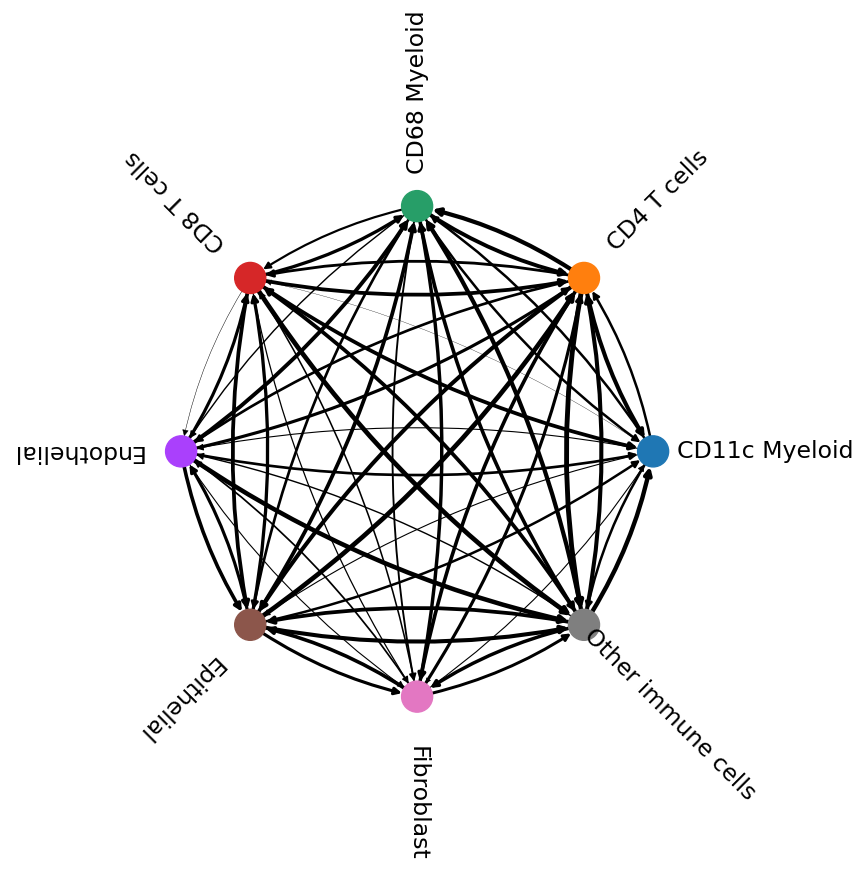

,sender,receiver,0,magnitude,de_genes,de_genes_abs
1,CD11c Myeloid,CD4 T cells,20,0.198203,0.516129,20
2,CD11c Myeloid,CD68 Myeloid,20,0.187180,0.516129,20
3,CD11c Myeloid,CD8 T cells,6,0.073178,0.064516,6
4,CD11c Myeloid,Endothelial,11,0.193197,0.225806,11
5,CD11c Myeloid,Epithelial,11,0.200863,0.225806,11
6,CD11c Myeloid,Fibroblast,4,0.127015,0.000000,4
7,CD11c Myeloid,Other immune cells,20,0.236690,0.516129,20
8,CD4 T cells,CD11c Myeloid,30,0.242913,0.838710,30
10,CD4 T cells,CD68 Myeloid,31,0.231479,0.870968,31
11,CD4 T cells,CD8 T cells,22,0.070555,0.580645,22


In [14]:
interpreter.type_coupling_analysis_circular(
    edge_attr='de_genes',
    edge_width_scale=3.5,
    de_genes_threshold=1,
    figsize=(9,9),
    text_space=1.35
)

### 3. Directional sender effects for Epithelial cells and CD8 T cells

We dissected these couplings based on the gene-wise effects of all senders on one receiver type for CD8T cells and Epithelial cells which contextualizes differential expression results of the CD8T cell–Epithelial cell axis.

NCEM correctly identifies genes and proteins that play roles in T-cell activation, regulation of T-cell antigen receptor signalling and immune response.

### a) Sender effects on CD8 T cells 

“Sender effect” analysis heatmap for CD8 T cells. Shown is the estimated log fold change that the sender cell type on the x-axis induces in the gene on the y axis in receiving CD8 T cells.

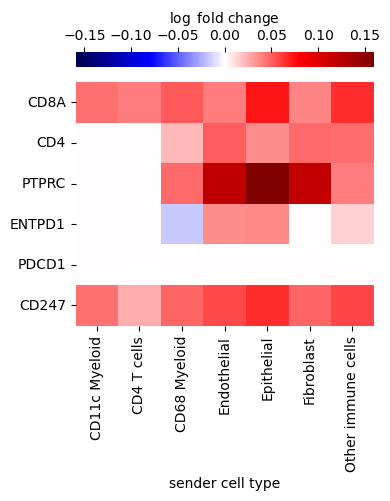

In [15]:
interpreter.sender_effect(
    receiver='CD8 T cells', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

### b) Sender effects on Epithelial cells

“Sender effect” analysis heatmap for Epithelial cells. Shown is the estimated log fold change that the sender cell type on the y-axis induces in the gene on the x axis in receiving Epithelial cells.

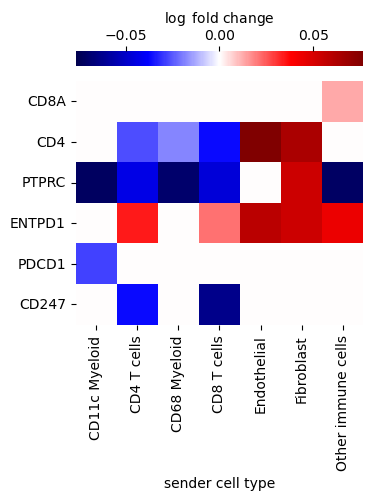

In [16]:
interpreter.sender_effect(
    receiver='Epithelial', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

### c) Directional effect for sender-receiver axis for CD8 T cells on Epithelial cells 

This analysis contextualizes differential expression results of the CD8 Tcell – Epithelial cell axis.

Volcano plot of differentially expressed genes of Epithelial cells in the neighborhood of CD8 T cells.

/home/ifichtner/mambaforge/envs/squidpyLatest/lib/python3.8/site-packages/ncem/interpretation/interpreter.py:1184: RuntimeWarning: divide by zero encountered in log10
  y=-np.log10(self.qvalues[receiver_idx,sender_idx,:])[qval_filter],
/home/ifichtner/mambaforge/envs/squidpyLatest/lib/python3.8/site-packages/ncem/interpretation/interpreter.py:1190: RuntimeWarning: divide by zero encountered in log10
  y = -np.nan_to_num(np.log10(self.qvalues[receiver_idx,sender_idx,:])[qval_filter])
/home/ifichtner/mambaforge/envs/squidpyLatest/lib/python3.8/site-packages/ncem/interpretation/interpreter.py:1198: RuntimeWarning: divide by zero encountered in log10
  y = -np.nan_to_num(np.log10(self.qvalues[receiver_idx,sender_idx,:])[qval_filter], neginf=-14.5)
/home/ifichtner/mambaforge/envs/squidpyLatest/lib/python3.8/site-packages/ncem/interpretation/interpreter.py:1206: RuntimeWarning: divide by zero encountered in log10
  y = -np.nan_to_num(np.log10(self.qvalues[receiver_idx,sender_idx,:])[qval_fil

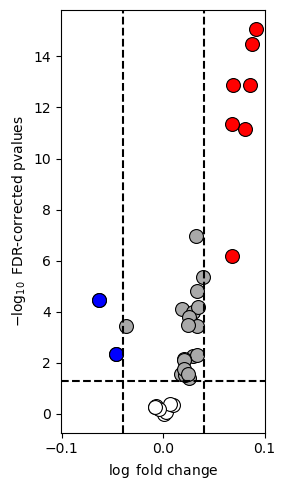

In [17]:
interpreter.sender_receiver_effect_vulcanoplot(
    sender='CD8 T cells', 
    receiver='Epithelial',
    fold_change_threshold=0.04,
    figsize=(3,5)
)

In [18]:
# low fold change
interpreter.sender_receiver_values(
    sender='CD8 T cells', 
    receiver='Epithelial'
).sort_values(by='fold change').head(5)

/home/ifichtner/mambaforge/envs/squidpyLatest/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mean expression,pvalue,qvalue,fold change,-log 10 qvalue
CD247,0.034301,0.000016,0.000033,-0.063058,4.478274
PTPRC,0.094684,0.002655,0.004596,-0.046619,2.337593
CD4,0.444059,0.000187,0.000361,-0.037043,3.442371
HK1,0.284720,0.466127,0.534838,-0.007994,0.271777
CD14,0.302856,0.443716,0.513902,-0.007706,0.289120


In [19]:
# high fold change
interpreter.sender_receiver_values(
    sender='CD8 T cells', 
    receiver='Epithelial'
).sort_values(by='fold change', ascending=False).head(5)

/home/ifichtner/mambaforge/envs/squidpyLatest/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mean expression,pvalue,qvalue,fold change,-log 10 qvalue
ATP1A1,0.600591,2.220446e-16,8.590144e-16,0.091495,15.066000
SLC1A5,0.617203,0.000000e+00,0.000000e+00,0.087557,inf
CKM,0.490008,3.819167e-14,1.374900e-13,0.085483,12.861729
SLC3A2,0.457782,2.115641e-12,6.959063e-12,0.080287,11.157449
CPT1A,0.606316,3.641532e-14,1.316436e-13,0.068386,12.880600


### d) Squidpy: Ligand-receptor interactions
Again, these core associations are reproduced by CellphoneDB. However only on receptor signaling genes. The shown result can be extracted with Squidpy.

NCEM is not limited to receptor signaling genes only.

In [20]:
# interpreter.data.ligrec(
#     fraction=0.70,
# )

### 4. Sender similarity analysis for Epithelial cells

“Sender similarity analysis” of all sender cell types with respect to Epithelial cell receivers. Shown is a clustered heatmap of Pearson correlation coefficients of the coefficient vectors of each sender type that corresponds to Epithelial cell receivers.

T cell clusters and other immune cells had a similar effect on Epithelial cells in a “sender similarity analysis”, in which we correlated the coefficient vectors of sender cell types that correspond to Epithelial cell receivers, which demonstrates conservation of cell type identity in the sender profile.

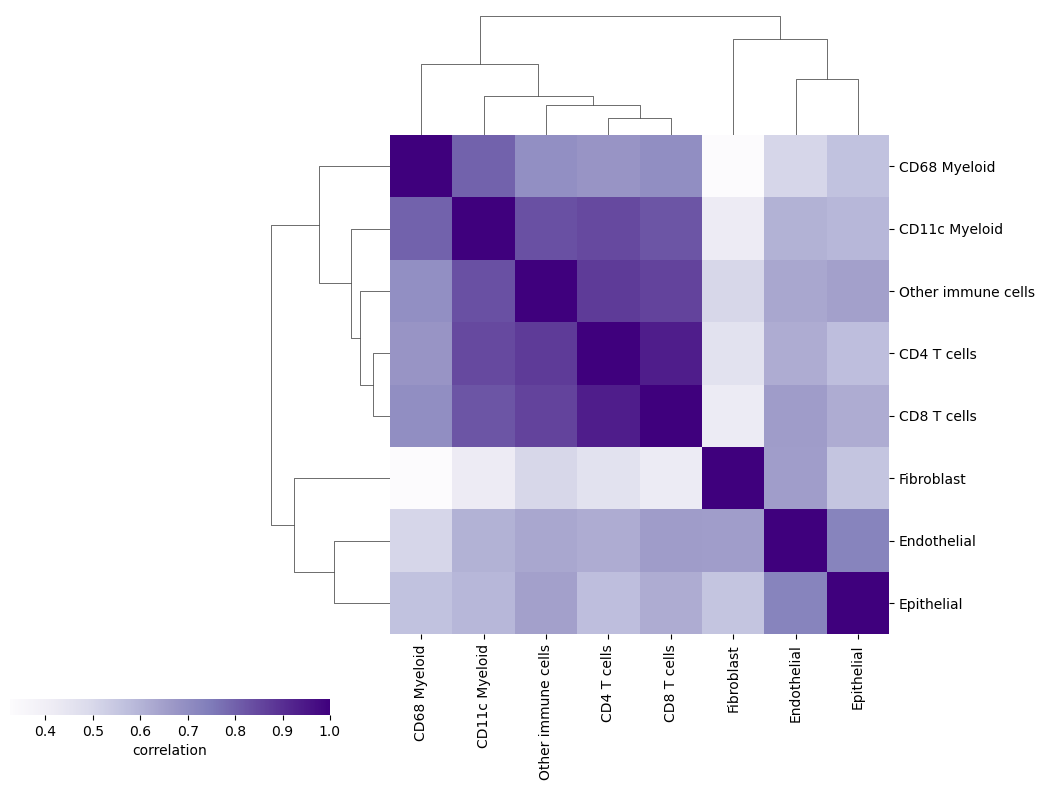

In [21]:
interpreter.sender_similarity_analysis(receiver='Epithelial')

### 5. Custom directional sender-receiver graph

Basis for custom wrapper
 - Equivalent to type-coupling analysis but introducing two optional parameters:
    - q-value threshold
    - fold-change threshold


In [81]:
# Custom wrapper function

import numpy as np
import scipy as sp

def ncem_sender_receiver_interactions(
    radius: int=35,
    n_eval_nodes: int=10,
    qval_thresh: float=0.05, 
    l1_thresh: int=0,
    fc_thresh=[0.00, 0.00],
    l2_thresh=0,
    plot: bool=True
    ):
    '''
    Calculates a custom sender-receiver graph based on interpreter.sender_effect()
     affected gene numbers per sender-receiver pair.

    Prerequisites:
     - import ncem
     - know what data loader you want to use
     - spatial data directories and files structured after the data loaders structure

    Input
     - Spatial features data
     - Parameters:
        - qval_thresh: FDR corrected p-value to be used as an upper-bound significance threshold
           (both L1 and L2 arrays)
        - l1_thresh: Minimum number of significant genes threshold for the L1 array.
        - fc_thresh:
            - Option 1: a list of two int or float numbers to be used as an upper-bound (first number)
               and lower-bound (second number)
               thresholds for the original coefficient values (only applied to L2 array).
            - Option 2: an int or float number. Assuming a normal distribution of coefficient values,
               the number indicates the standard deviation to be used as a cutoff. Only values above and
               below the mean +/- the standard deviation will be included (only on L2 norm array).
        - l2_thresh:
            - Option 1: Lower-bound threshold for computed L2 norm values (L2 array only).
            - Option 2: Use a specific percentile as a lower-bound threshold for computed
               L2 norm values (L2 array only).
               Notation str('AXX'), where 'A' is short for 'Above' and the 'XX' are strictly
               two numbers (int) to be considered as the lower-bound percentile threshold.

    Output:
     - List of 2 numpy arrays:
        - 1. Type-coupling (Sender-receiver effect) interaction matrix
            L1 norm of the number of significant interaction terms per cell
        - 2. Sender-receiver magnitude effect interaction matrix
            L2 norm of interacton term coefficients of genes per cell
        - dim(cell-types x cell-types)
            - [receiver, sender]
    '''

    # Some relevant variables
    clusters = interpreter.cell_names
    num_clusters = len(clusters)
    vars = interpreter.data.var_names
    num_vars = len(vars)
    qvals = interpreter.qvalues

    # interpreter.fold_change
    #  - numpy array of shape [8, 8 , 36] = [receiver clusters, sender clusters, features]
    #  - dtype=float32



    # L1-signigicance interaction matrix

    l1_effects = interpreter.fold_change

    # Filter out genes under corrected qval
    l1_effects = l1_effects * (qvals < qval_thresh)

    # L1 norm AKA Count genes > 0 per sender-receiver pair
    l1_effects = np.sum(l1_effects != 0, axis=2)

    # Filter out sender-receiver effects A.K.A node edges > nr_genes_thresh
    l1_effects = np.where(l1_effects > l1_thresh, l1_effects, np.zeros([num_clusters, num_clusters]))

    np.fill_diagonal(l1_effects, 0)



    # L2-coefficient interaction matrix

    l2_effects = interpreter.fold_change

    # Filter out genes under/over fc_thresh

    try:

        if isinstance(fc_thresh, list) & (len(fc_thresh) == 2) & isinstance(fc_thresh[0], (int, float)) & isinstance(fc_thresh[1], (int, float)):

            l2_effects = np.where((l2_effects < fc_thresh[0]) | (l2_effects > (fc_thresh[1])), l2_effects, np.zeros([num_clusters, num_clusters, num_vars]))

    except: 

        if isinstance(fc_thresh, (int, float)):
            
            mean = np.mean(l2_effects)
            std = np.std(l2_effects)

            l2_effects = np.where((l2_effects < (mean - (fc_thresh * std))) | (l2_effects > (mean + (fc_thresh * std))), l2_effects, np.zeros([num_clusters, num_clusters, num_vars]))
        
        else:
            raise Exception(f'{fc_thresh} doesnt comply with possible parameter types.')


    # BUG! features aren't filtered correctly
    # Filter out genes under corrected qval
    # print(qvals[3,5, 16])
    # print(qval_thresh)
    # print("Before")
    # print(l2_effects[3,5,16])
    l2_effects = l2_effects * (qvals < qval_thresh)
    # print("After")
    # print(l2_effects[3,5,16])
    qvals = np.where(qvals < 0.01, qvals, np.zeros([8,8,36]))
    # print(sp.stats.describe(qvals.flatten()))

    # L2 norm
    l2_effects = np.sqrt(np.sum(l2_effects ** 2, axis=-1))

    # Filter out sender-receiver effects A.K.A L2 score > l2_thresh
    if isinstance(l2_thresh, (int, float)):

        l2_effects = np.where(l2_effects > l2_thresh, l2_effects, np.zeros([num_clusters, num_clusters]))
    
    elif isinstance(l2_thresh, str) & (len(l2_thresh) == 3):
        
        try:
            
            _ = l2_thresh[0] == 'A'
            int_number = int(l2_thresh[1:3])

            percentile =  np.percentile(l2_effects, int_number)

            l2_effects = np.where(l2_effects > percentile, l2_effects, np.zeros([num_clusters, num_clusters]))


        except ValueError:

            print('l2_thresh doesnt comply with the parameter possibilities.')
    
    else:

        print('l2_thresh doesnt comply with the parameter possibilities.')

    np.fill_diagonal(l2_effects, 0)


    # Heatmap
    if plot == True:

        fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True)

        im0 = ax0.imshow(l1_effects, cmap='gray_r')
        im1 = ax1.imshow(l2_effects, cmap='gray_r')
        ax0.set_title('Sender-receiver effects:\nL1(significance)', y=1.1)
        ax1.set_title("Sender-receiver effects:\nL2(interaction terms)", y=1.1)

        for ax in fig.get_axes():
            
            ax.set_xlabel('Senders')
            ax.set_xticks([i for i in range(0,8)])
            ax.set_xticklabels(interpreter.cell_names, rotation=90)

            ax.set_ylabel('Receivers')
            ax.set_yticks([i for i in range(0,8)])
            ax.set_yticklabels(interpreter.cell_names)

            ax.label_outer()

        fig.colorbar(im0, ax=ax0, shrink=0.49)
        fig.colorbar(im1, ax=ax1, shrink=0.49)

        plt.show()

    return [l1_effects, l2_effects]

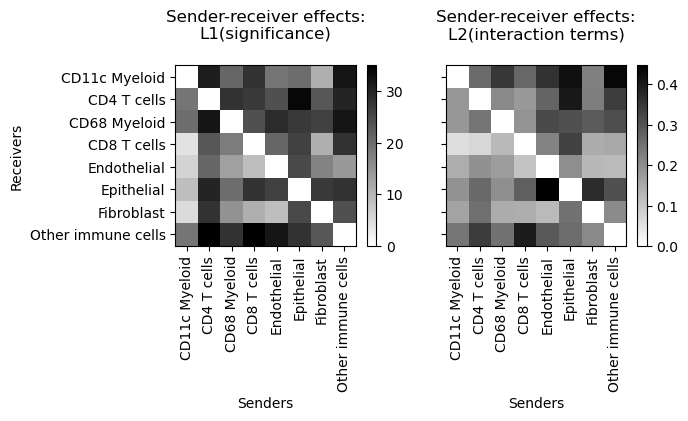

In [85]:
# Applying the function
ncem_interactions = ncem_sender_receiver_interactions(
    radius=35,
    n_eval_nodes=10,
    qval_thresh=0.05,
    l1_thresh=0,
    fc_thresh=0,
    l2_thresh=0 # ='A90'
)
